<a href="https://colab.research.google.com/github/Sagar-modelling/Handwriting_Recognition_CRNN_LSTM/blob/main/text_recognition_webapp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [180]:
!pip install -U ipykernel

t=2021-10-16T12:14:40+0000 lvl=eror msg="failed to reconnect session" obj=csess id=a46a2c09d57e err="dial tcp: i/o timeout"

t=2021-10-16T12:14:41+0000 lvl=warn msg="failed to start tunnel" pg=/api/tunnels id=eeefcc2e1013f572 err="session closed"



In [2]:
!pip install -q streamlit

In [3]:
!pip install pyngrok==4.1.1

In [4]:
!ngrok authtoken 1zZv59zElKCH3oaXyLhNql3u7j6_bNtjEETUcqzMgeuZWhxE

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [174]:
%%writefile score.py

import tensorflow as tf
import streamlit as st
import numpy as np
from PIL import Image
import os
import cv2
import random
from io import BytesIO
import pandas as pd
import matplotlib.pyplot as plt
from skimage import color
from skimage import io
from keras import backend as K
from keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

st.set_option('deprecation.showfileUploaderEncoding', False)
st.title("Text Recognizer")
st.text("Input Text Image for Recognition")

def preprocess(img):
  (h, w) = img.shape

  final_img = np.ones([64, 256])*255 # black white image

  # crop
  if w > 256:
    img = img[:, :256]
      
  if h > 64:
    img = img[:64, :]


  final_img[:h, :w] = img
  return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

alphabets = u"!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz "
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank(epsilon)

def num_to_label(num):
  ret = ""
  for ch in num:
    if ch == -1:  # CTC Blank
      break
    else:
      ret+=alphabets[ch]
  return ret

input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

#@st.cache(allow_output_mutation=True)
model.load_weights('/content/drive/MyDrive/trained weights/C_LSTM_best.hdf5')

with st.spinner('Loading Model into Memory......'):

  #plt.figure(figsize=(1, 1))
  #Uploading the File to the WebPage
  path = st.file_uploader(label="Upload image", type=['jpg', 'png'])
  st.image(path, caption='Image to be recognized', use_column_width=True)
  if path is not None:
    st.write("Recognized Text:")
    with st.spinner('Recognizing......'):
      plt.figure(figsize=(5, 5))
      file_bytes = np.asarray(bytearray(path.read()), dtype=np.uint8)
      opencv_image = cv2.imdecode(file_bytes, 1)
      image = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2GRAY)
      image = preprocess(image)
      image = image/255.0
      pred = model.predict(image.reshape(1, 256, 64, 1))
      decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
      st.text(num_to_label(decoded[0]))

Overwriting score.py


In [177]:
!nohup streamlit run score.py &

nohup: appending output to 'nohup.out'


In [ ]:
from pyngrok import ngrok

url = ngrok.connect(port=8501)
url

In [178]:
!cat nohup.out


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://104.196.110.222:8501


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8502
  External URL: http://104.196.110.222:8502

2021-10-16 07:28:27.111 Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/streamlit/script_runner.py", line 354, in _run_script
    exec(code, module.__dict__)
  File "/content/score.py", line 13, in <module>
    from keras.optimizers import Adam
ImportError: cannot import name 'Adam' from 'keras.optimizers' (/usr/local/lib/python3.7/dist-packages/keras/optimizers.py)

2021-10-16 07:28:36.219 Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/streamlit/script_runner.py", line 354, in _run_script
    exec(code, module.__dict__)
  File "/content/score.py", line 13, in <module>
    from keras.optimizers import Adam
ImportError: cannot import name 'Adam

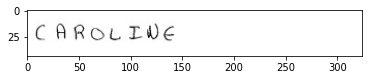

In [104]:
import matplotlib.image as mpimg
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
img = mpimg.imread('/content/TEST_0040.jpg') 
image = rgb2gray(img)  
plt.imshow(image, cmap='gray')